𝑅_𝑛−𝐺_𝑠=𝐿𝐸+𝐻

𝑅_𝑛=(1 − 𝛼_𝑠 ) 𝑅_𝑠𝑖+𝑅_𝑖𝑙−𝜖_𝑠 𝜎𝑇_𝑠^4

𝛼_𝑠  depends on soil moisture


The z0 values over the desert and the field respectively were taken as 0.005 m and 0.05 m. 

The surface roughness for heat and moisture (z0r) was assumed to be zo/5 


h = actual canopy height?
d = 2/3*h

In [1]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import pandas as pd
import numpy as np

for mod in ["sutton_functions"]:
    if mod in sys.modules:
            del sys.modules[mod]
            
from sutton_functions import *

# https://pypi.org/project/era5cli/

CPU times: user 1.27 s, sys: 1.73 s, total: 3 s
Wall time: 856 ms


In [2]:
import xarray as xr
ds = xr.open_dataset("data_stream-oper_stepType-instant.nc", engine='h5netcdf')

In [3]:
lat = ds['latitude'].values
lon = ds['longitude'].values

# Coordinates of interest
lat_point = 45.6667
lon_point = -119.6667

# Find the closest indices
lat_idx = (np.abs(lat - lat_point)).argmin() + 1
lon_idx = (np.abs(lon - lon_point)).argmin() + 1

# Extract data at the closest point
data_at_point = ds.isel(latitude=lat_idx, longitude=lon_idx)


In [4]:

def get_lm(k,h,z, option = 'kz'):
    """
    mixing length option
    """
    d = 2/3*h
    
    if option == 'kz':
        lm = k*z
    else:
        a = 1
        lm = k*z   # k*a*(h/3)
        lm[z < a*(h - d)] = k*a*h/3 
    
        # lm = k*(z - d)    
        # lm[z < h] = k*h/3      
    return lm



In [5]:
def our_central_difference(s, dz):
    """
    Computes gradients of a data vector using central differencing. At edges, 
    forward and  backward differences are used
    """
    m = len(s)
    dsdz = np.zeros(m)
    
    # Central difference for interior points
    dsdz[1:m-1] = (s[2:m] - s[0:m-2]) / (2 * dz)
    #dsdz[1:m-1] = (s[2:m] - s[1:m-1]) / ( dz)
    
    # Forward difference at the first node
    dsdz[0] = (s[1] - s[0]) / dz
    
    # Backward difference at the last node
    dsdz[m-1] = (s[m-1] - s[m-2]) / dz
    
    return dsdz

In [37]:

def vapor_concentration_RH( T, RH = 100):
    """
    Calculate the vapor concentration (in g/m³) for a given 
    relative humidity (RH) and temperature (T in °C).
    
    Parameters:
    - RH (float): Relative humidity as a fraction (e.g., 0.5 for 50%).
    - T (float): Temperature in degrees Celsius.
    
    Returns:
    - float: Vapor concentration in g/m³.
    """
    # Constants
    M_w = 18.015  # molar mass of water vapor in g/mol
    R = 8.314  # universal gas constant in J/(mol*K)
    
    # Calculate the saturation vapor pressure (Pa)
    e_s = 6.1094 * math.exp((17.625 * T) / (T + 243.04))*100

    # Actual vapor pressure (Pa)
    e = RH/100 * e_s
    
    # Vapor concentration (g/m³)
    C = (e * M_w) / (R * (T + 273.15))
    
    return C

def get_e_sat(T) :
     
    #  T (float): Temperature in degrees Celsius.    
    e_s = 6.1094 * math.exp((17.625 * T) / (T + 243.04))*100
    
    return e_s

def vapor_concentration(es, T):
    # Constants
    M = 18.015  # Molar mass of water in g/mol
    R = 8.314  # Universal gas constant in J/(mol·K)
    
    # Water vapor concentration calculation
    rho = (es * M) / (R * T)
    return rho


In [178]:
# Define given values
mcal_to_J = 4.184e-3  # 1 mcal = 4.184e-3 J
cm2_to_m2 = 1e-4      # 1 cm² = 1e-4 m²
H01_mcal_cm2_s = 8.5  # Given value in mcal/cm²/s

# Convert to SI units (W/m²)
H_f = H01_mcal_cm2_s * mcal_to_J / cm2_to_m2

LE_f = 0

# Rn - G = H_f
Q_f = 6.34 # g mm3, E_01

RH_c = 60 # %

# h should be 4 cm?  literal canopy height?
d = 2/3*0.04

In [52]:
def get_params(fallow_fraction = 0.5, fallow_length = 1000, 
               T_sc = 30, T_sf = 50, T_a = 18, 
               Q_a = 5, Q_c = 20, RH_c = 60,
               h = 0.04, 
               zom_f = 0.14/100, # m 0.002
               zom_c = 0.14/1000, # m 
               SW_in = 400, 
               e_f = 0.95, e_c = 0.95, e_a = .8,
               alpha_c = 0.22, alpha_f = 0.22,
               lm_option = 'kz', adj_grid = 0
              ):
    
    # Flat parameter dictionary
    params = {
        "k": 0.4,            # von Karman constant        
        "zom_f": zom_f,      # Momentum roughness length (m)
        "zom_c": zom_c,      # Momentum roughness length (m)        
        'h' : h,
        "Lx": 1000,           # Domain length in x-direction
        "Hmax": 10,           # Maximum height

        'H_f' : H_f,
        "fallow_fraction": fallow_fraction,
        "fallow_length" : fallow_length,
        "dz": 0.05,
        "dx": 1,

        'Q_f' : Q_a,
        'Q_a' : Q_a,   
        'T_sc' : T_sc,  # Cultivated temperature
        'T_sf' : T_sf,  # Fallow temperature
        
        'SW_in' : SW_in,
        'T_a' : T_a,  # Atmos temperature
        'e_a' : e_a,
        'e_f' : e_f,
        'e_c' : e_c,
        'alpha_c' : alpha_c,
        'alpha_f' : alpha_f,  
        'lm_option' : lm_option,
        'adj_grid' : adj_grid,
        'RH_c' : RH_c
    }
    #Ubar_4 = 3.76
    #ustar_f = 0.4*Ubar_4/np.log(4/zom_f)    # Friction velocity (m/s)
    #ustar_c = 0.4*Ubar_4/np.log(4/zom_c)

    ustar_f = 15/100 # m/s
    params['xmin'] = 0
    params['ustar_f'] = ustar_f
    params['ustar_c'] = ustar_f    
    params['xmax'] = params['Lx']
    params['zmin'] = params['zom_f']
    params['zmax'] = params['Hmax']
    
    params['field_size'] = int(params['fallow_length']/params['dx'])
    
    if fallow_fraction > 0:
        params['fallow_size'] = int(params['field_size']*(1- fallow_fraction)/fallow_fraction)
    else:
        params['fallow_size'] = 0
        
    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
    nz = len(z)
    x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])
    nx = len(x)   
    
    es_c = saturation_vapor_pressure(T_sc + 273.15)
    es_f = saturation_vapor_pressure(T_sf + 273.15)
    params['nx'] = nx
    params['nz'] = nz
    
    es_c = saturation_vapor_pressure(T_sc + 273.15)
    Q_c = vapor_concentration_RH(T_sc, RH_c)

    params['Q_c'] = Q_c
    
    return params

def get_zc(params):
    
    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
    dz = params['dz']
    nz = params['nz']    
    zc = z.copy()    
    zc[0] = dz / np.log(z[1]/z[0])
    for i in range(1, nz-1):
        zc[i] = dz*2/ np.log(z[i+1]/z[i-1])
    zc[-1] = dz / np.log(z[-1]/z[-2])
    
    return nz

In [76]:
def uniform_Q(params):
    """
    The function computes an implicit solution for water vapor concentration and
    flux in a turbulent boundary layer.
    
    - Uses an implicit finite-difference method for solving the transport equation.
    - Implements mixing length theory to define eddy diffusivity.
    - Marches along the x-direction to iteratively solve for the concentration field.

    """
    nx = params['nx']
    nz = params['nz']    
    dx = params['dx']    
    dz = params['dz']  
    zmax = params['zmax']      
    k = params['k']          
    
    ustar_f = params['ustar_f']
    zom_f = params['zom_f']  
    zoh_f = params['zom_f']/5    
    
    ustar_c = params['ustar_c']
    zom_c = params['zom_c']  
    zoh_c = params['zom_c']/5
    
    Q_f = params['Q_f']
    Q_c = params['Q_c']
    Q_a = params['Q_a']
    h = params['h']
    lm_option = params['lm_option']
    adj_grid = params['adj_grid']

    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], 
                  params['dz'])    

    LE_f = ustar_f*k*(Q_f - Q_a)/np.log(zmax/zom_f)
    Qup = Q_f - LE_f/(k*ustar_f)*np.log(z/zom_f)
    
    LE_c = ustar_c*k*(Q_c - Q_a)/np.log(zmax/zom_c)
    Qdown = Q_c - LE_c/(k*ustar_c)*np.log(z/zom_c)    
    
    U = (ustar_c / k) * np.log(z / zom_c)
    
    lm = get_lm(k, h, z, lm_option)    
    
    # Setup coefficients for the implicit scheme
    A = lm * ustar_c
    B = 1.0 / U
    C = our_central_difference(A, dz)

    # Upwind wv concentrations and fluxes
    Q1 = Qup
    Q_uniform = np.zeros((nx , nz))
    Q_uniform[0, :] = Q1
    FluxQ_uniform = np.zeros((nx , nz))

    # Begin downwind calculations by marching along x
    for i in range(nx):
        Q2, Fq = integrate_H2O_implicit(nx, nz, dx, dz, A, B, C, Q1, Qdown[0], Q_a)
        Q_uniform[i, :] = Q2
        FluxQ_uniform[i, :] = Fq
        Q1 = Q2

        
    return Q_uniform, FluxQ_uniform

def uniform_T(params):
    """
    The function solves an implicit equation for temperature transport in a turbulent boundary layer.
    
    - Uses an implicit finite-difference method to solve the advection-diffusion equation.
    - Mixing length theory is applied to define eddy diffusivity.
    - Marches along the x-direction to iteratively compute the temperature field.
    
    """
    nx = params['nx']
    nz = params['nz']    
    dx = params['dx']        
    dz = params['dz']        
    k = params['k']              
    zmax = params['zmax']
    
    ustar_f = params['ustar_f']
    zom_f = params['zom_f']  
    zoh_f = params['zom_f']/5    
    ustar_c = params['ustar_c']
    zom_c = params['zom_c']  
    zoh_c = params['zom_c']/5
    
    T_sf = params['T_sf']    
    T_sc = params['T_sc']
    T_a = params['T_a']
    h = params['h']    
    
    lm_option = params['lm_option']
    adj_grid = params['adj_grid']
    
    z = np.arange(params['zmin'] + params['dz'], 
                  params['zmax'] + params['dz'], params['dz'])
    
    wT = - (T_a - T_sf)*k*ustar_f/np.log(zmax/zom_f)      # K m/s
    Tup = T_sf - wT/(k*ustar_f)*np.log(z/zom_f)

    wT_down = -(T_a - T_sc)*k*ustar_c/np.log(zmax/zom_c)  # K m/s    
    Tdown = T_sc - wT_down/(k*ustar_c)*np.log(z/zom_c)

    U = (ustar_c / k) * np.log(z / zom_c)    
    
    # Setup coefficients for the implicit scheme
    lm = get_lm(k, h, z, lm_option)       
    A = lm * ustar_c
    B = 1.0 / U
    C = our_central_difference(A, dz)

    # Upwind wv concentrations and fluxes
    T1 = Tup
    T_uniform = np.zeros((nx , nz))
    T_uniform[0, :] = T1
    FluxT_uniform = np.zeros((nx , nz))

    for i in range(nx):
        
        T2, FT = integrate_T_implicit(nx, nz, dx, dz, A, B, C, T1, Tdown[0], T_a)
        T_uniform[i, :] = T2
        FluxT_uniform[i, :] = FT
        T1 = T2
    
    return T_uniform, FluxT_uniform

In [158]:
# downwind humidity is 60%
G  = 30
Rn_f = H_f + G
Rn_c = 1.2*H_f + G

SW = 700
T_a = 16 + 273.15
Q_a = 5

epsilon_a = 0.95
epsilon_f = 0.95
epsilon_c = 0.95

params = get_params(h = 2.3, SW_in = SW, 
               e_f = epsilon_f, e_c = epsilon_c, e_a = epsilon_a,            
               lm_option = 'kz', adj_grid = 0)

z_h = params['Hmax']

zom_f = params['zom_f']
zom_c = params['zom_c']
zoh_f = params['zom_f']/5
zoh_c = params['zom_c']/5

k = params['k']
ustar_f = params['ustar_f']
ustar_c = params['ustar_c']

z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])

from sympy import symbols, Eq, solve

# Define symbols
sigma_sb = 5.67*1e-8

Q_f = Q_a
Q_c =  Q_f + 8

T_sf, T_sc, alpha_f, alpha_c, H_c, LE_c = symbols('T_sf T_sc alpha_f alpha_c H_c  LE_c')

level = 5
# unknowns – alpha_f, T_sf
eq1 = Eq(SW*(1-alpha_f) + epsilon_a*sigma_sb*T_a**4 - epsilon_f*sigma_sb*T_sf**4, Rn_f )

eq2 = Eq(SW*(1-alpha_c) + epsilon_a*sigma_sb*T_a**4 - epsilon_c*sigma_sb*T_sc**4, Rn_c )

eq3 = Eq(T_sf - T_a, 1/(k*ustar_f)*H_f/((1005*1.2))*np.log(z_h/(z[level])))

eq4 = Eq(T_sc - T_a, 1/(k*ustar_c)*H_c/((1005*1.2))*np.log(z_h/(z[level])))

eq5 = Eq(Q_c - Q_a, 1/(k*ustar_c)*LE_c/2260*np.log(z_h/(z[level])))

eq6 = Eq(Rn_c - G, LE_c +  H_c)

# Solve the system of equations
solution = solve((eq1, eq2, eq3,  eq4, eq5, eq6), 
                 (T_sf, T_sc, alpha_f, alpha_c, LE_c,  H_c ))

# T_sf, Q_f are the boundary conditions at level = 5 (top of canopy..?)
T_sf, T_sc, alpha_f, alpha_c, LE_c,  H_c = solution[0]

T_a = T_a - 273.15
T_sf = T_sf - 273.15
T_sc = T_sc - 273.15


In [159]:
T_sf, T_sc,T_sf -  T_sc, alpha_f, alpha_c, LE_c,  H_c

(33.2113938334459,
 21.6619644740986,
 11.5494293593473,
 0.309118113276778,
 0.304089218312969,
 309.774509231375,
 116.993490768625)

In [160]:
(T_sf - T_a)*(k*ustar_f)*((1005*1.2))/np.log(z_h/(z[level])), H_f

(355.640000000000, 355.64)

In [161]:
Q_c, float(vapor_concentration_RH(float(T_sc), RH_c)), RH_c

(13, 11.398097311479805, 60)

In [162]:
T_zom_f = np.log(z_h/zom_f)/np.log(z_h/z[level])*(T_sf - T_a) + T_a
T_zom_c = np.log(z_h/zom_c)/np.log(z_h/z[level])*(T_sc - T_a) + T_a

Q_zom_f = np.log(z_h/zom_f)/np.log(z_h/z[level])*(Q_f - Q_a) + Q_a
Q_zom_c = np.log(z_h/zom_c)/np.log(z_h/z[level])*(Q_c - Q_a) + Q_a

print (T_zom_f, T_sf, "\n", T_zom_c, T_sc,"\n", Q_zom_c, alpha_f)

59.6139091163301 33.2113938334459 
 34.0703742067002 21.6619644740986 
 30.532303198814372 0.309118113276778


In [163]:
sigma_sb = 5.67*1e-8

params = get_params(T_sc = float(T_zom_c), T_sf = float(T_zom_f), 
                    Q_c = float(Q_zom_c), Q_a = Q_a, T_a = T_a, SW_in = SW, 
                    alpha_f = alpha_f, alpha_c = alpha_c)

In [164]:
LE_c, (Q_c - Q_a)*(k*ustar_c)*2260/np.log(z_h/(z[level]))

(309.774509231375, 309.7745092313746)

In [165]:
LW_out_c = epsilon_c*sigma_sb*(T_sc + 273.15)**4
LW_in_c = epsilon_a*sigma_sb*(T_a + 273.15)**4

Rn_c = (1 - alpha_c)*SW  + LW_in_c - LW_out_c

In [166]:
Rn_c - G, LE_c + H_c

(426.767999999997, 426.768000000000)

In [167]:
T_uniform, FluxT_uniform = uniform_T(params)
Q_uniform, FluxQ_uniform = uniform_Q(params)

SH = FluxT_uniform*1005*1.2
LE = FluxQ_uniform*2.5*1e6/1000
FluxTotal = SH + LE

In [168]:
FluxT_uniform[-1][level]*1005*1.2, H_c

(53.473078063655464, 116.993490768625)

In [169]:
FluxQ_uniform[-1][level]*2.5*1e6/1000, LE_c

(110.52235398741935, 309.774509231375)

In [170]:
def get_upwind_fluxQ(params):
    """
    """
    ustar = params['ustar_f']    
    dz = params['dz']
    nz = params['nz']
    k = params['k']
    zmax = params['zmax']
    zoh = params['zom_f']
    h = params['h']
    nx = params['nx']     
    lm_option = params['lm_option']
    adj_grid = params['adj_grid']

    z = np.arange(params['zmin'] + params['dz'],
                  params['zmax'] + params['dz'], params['dz'])
    
    zc = get_zc(params)
    
    k = params['k']
    Q_f = params['Q_f']
    Q_a = params['Q_a']
    
    LE_f = ustar*k*(Q_f - Q_a)/np.log(zmax/zom_f)

    Qup = Q_f - LE_f/(k*ustar)*np.log(z/zom_f)
    dQdz = our_central_difference(Qup, dz)

    lm = get_lm(k,h, z, lm_option)
    
    A = lm * ustar
    
    FluxQ_upwind = np.zeros_like(Qup)    
    FluxQ_upwind[1:] = - 0.5 * (A[1:] + A[:-1]) * (0*dQdz[:-1] + dQdz[1:]) * 0.5

    FluxQ_upwind[1] = FluxQ_upwind[2]
    FluxQ_upwind[0] = FluxQ_upwind[1] 
    
    # FluxQ_upwind = - A * dQdz
    
    return Qup, FluxQ_upwind

def get_upwind_fluxT(params):
    """
    """
    dz = params['dz']
    nz = params['nz']
    nx = params['nx']    
    ustar = params['ustar_f']
    zmax = params['zmax']
    zoh_f = params['zom_f']/5
    zom_f = params['zom_f']
    h = params['h']
    lm_option = params['lm_option']    
    adj_grid = params['adj_grid']    
    
    z = np.arange(params['zmin'] + params['dz'],
                  params['zmax'] + params['dz'], params['dz'])
    
    k = params['k']
    T_sf = params['T_sf']
    T_a = params['T_a']
    Q_a = params['Q_a']        
    
    wT = - (T_a - T_sf)*k*ustar/np.log(zmax/zom_f) # K m/s
    Tup = T_sf - wT/(k*ustar)*np.log(z/zom_f)
    
    dTdz = our_central_difference(Tup, dz)

    ustar = params['ustar_f']
    k = params['k']

    lm = get_lm(k, h, z, lm_option)    
    A = lm * ustar

    # FluxT_upwind = - A * dTdz
    
    FluxT_upwind = np.zeros_like(Tup)
    FluxT_upwind[1:] = - 0.5 * (A[1:] + A[:-1]) * (0*dTdz[:-1] + dTdz[1:]) * 0.5
    
    FluxT_upwind[1] = FluxT_upwind[2]
    FluxT_upwind[0] = FluxT_upwind[1]
    
    return Tup, FluxT_upwind

Qup, FluxQ_upwind = get_upwind_fluxQ(params)
Tup, FluxT_upwind = get_upwind_fluxT(params)



In [171]:
x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])

FluxTotal_upwind = FluxQ_upwind[level]*np.ones_like(x)*2.260*1e6/1000 + \
            FluxT_upwind[level]*np.ones_like(x)*1005*1.2

-0.0 166.2975787688499
54.079460654743905 100.99755881345085


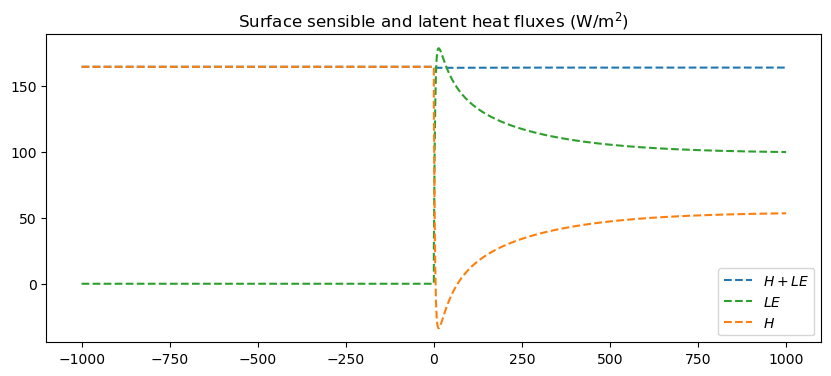

In [172]:

plt.figure(figsize = (10, 4 ))
ax = plt.gca()

x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])
xx = np.concatenate([-np.flip(x),x])

FluxTotal_ = np.concatenate([FluxTotal_upwind, FluxTotal[:, level]])

FluxTotal_upwind = FluxQ_upwind[level]*np.ones_like(x)*2.260*1e6/1000 + \
            FluxT_upwind[level]*np.ones_like(x)*1005*1.2

ax.plot(xx, FluxTotal_,  c =  'C0', ls = '--', label = '$H + LE$')

FluxQ = np.concatenate([FluxQ_upwind[level]*np.ones_like(x), FluxQ_uniform[:, level]])
ax.plot(xx,FluxQ*2.260*1e6/1000,  ls = '--', c =  'C2',  label = "$LE$")

FluxT = np.concatenate([FluxT_upwind[level]*np.ones_like(x), FluxT_uniform[:,level]])
ax.plot(xx, FluxT*1005*1.2,  c =  'C1', ls = '--', label = "$H$")
ax.legend()
ax.set_title("Surface sensible and latent heat fluxes (W/m$^2$)")

level = 6
print (FluxQ_upwind[level]*2260,  FluxT_upwind[level]*1005*1.2)
print (FluxT_uniform[ -1, level]*1005*1.2, FluxQ_uniform[ -1, level]*2260)


In [173]:
fig6data = pd.read_csv('baldocchi1995/baldocchi1995_fig6.csv')

In [174]:
# 4 m above the surface
# assume a 1 m canopy
# 3 m above the canopy
# z = height above canopy - d


In [175]:

# i800 = np.where(x > 800)[0][0]
# plt.scatter(fig6data['x'], fig6data[' y'], label = "Baldocchi and Rao, 1995")
# # level = 3
# # plt.plot(x[:i800], FluxQ_uniform[:i800, level]/FluxQ_uniform[i800, level])

# level = 40
# plt.plot(x[:i800], FluxQ_uniform[:i800, level]/FluxQ_uniform[i800, level])
# plt.xlabel("x")
# plt.xlabel("ET/ET(800m)")

177.66547025845543

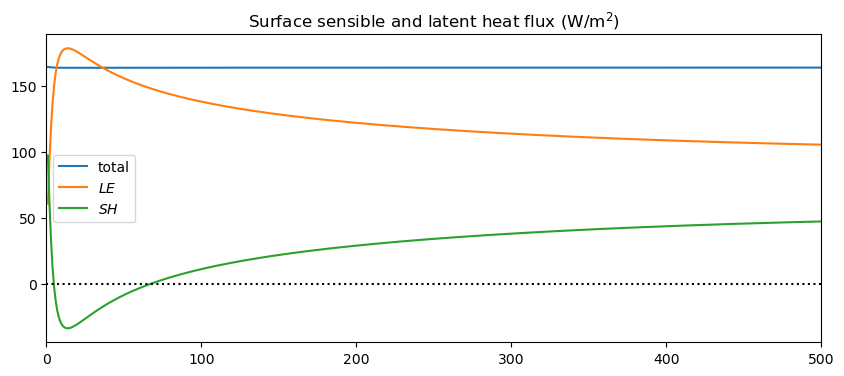

In [176]:
x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])

level = 5
plt.figure(figsize = (10,4))
ax = plt.gca()
ax.plot(x[1:], FluxTotal[1:, level], label = 'total')
ax.plot(x[1:], FluxQ_uniform[1:, level]*2.260*1e6/1000, label = "$LE$")
ax.plot(x[1:], FluxT_uniform[1:, level]*1005*1.2, label = "$SH$")
ax.axhline(FluxT_uniform[-1, level], ls = ':', c = 'k')
ax.legend()
ax.set_xlim(0, 500)
ax.set_title("Surface sensible and latent heat flux (W/m$^2$)")

FluxTotal[level, -1]

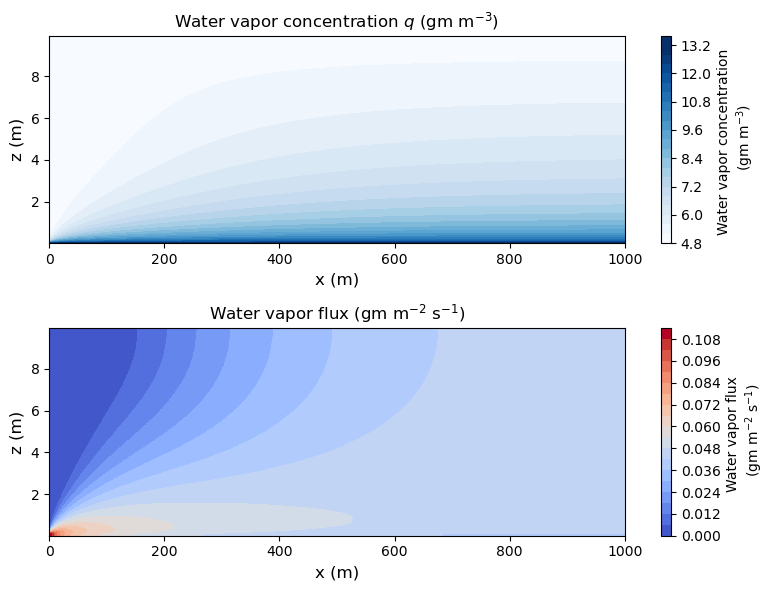

In [177]:
z = np.arange(params['zmin'], params['zmax'] + params['dz'], params['dz'])
x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])

# Plot water vapor concentration and vertical flux
plt.figure(figsize = (8, 6))

plt.subplot(2, 1, 1)
nz = Q_uniform.shape[1]
plt.contourf(x, z[:nz], (Q_uniform.T), 25, cmap='Blues',  vmax = Q_c, vmin = Q_a)
plt.colorbar(label='Water vapor concentration \n (gm m$^{-3}$)')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor concentration $q$ (gm m$^{-3}$)', fontsize=12)

plt.subplot(2, 1, 2)
plt.contourf(x, z[:nz], FluxQ_uniform.T.round(4),  20, cmap='coolwarm', vmin = 0, vmax = FluxQ_uniform.max())
plt.colorbar(label='Water vapor flux \n (gm m$^{-2}$ s$^{-1}$)') 
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
plt.tight_layout()

